<a href="https://colab.research.google.com/github/polrgn/deep_learning_of_color_names/blob/main/colors_Paul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3: Colors and Word Models.

The following cells describe how to build a neural network that generates color names from RGB values.

We can give the neural network a list of paint colors (14157) along with their RGB values. (RGB = red, green, and blue color values).

Could the neural network learn to invent new paint colors and give them "meaningful" names?

## Setting up the environment and data

Library imports

In [ ]:
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import preprocessing
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, LSTM, GRU, Reshape, TimeDistributed, RepeatVector, Embedding, Bidirectional, Masking
import os
import numpy as np
import pandas
import matplotlib.pyplot as plt
import io
import requests
import random

np.random.seed(10)
print (tf.__version__)

2.4.0


Mounting of Google drive

In [ ]:
# Mounting Google drive where we save our data and embeddings
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Getting the dataset of color names and corresponding RGB vectors.

In [ ]:
url="https://raw.githubusercontent.com/Tony607/Keras-Colors/master/colors.csv"
s=requests.get(url).content
data=pandas.read_csv(io.StringIO(s.decode('utf-8')))
data.head(20)


,name,red,green,blue
0,parakeet,174,182,87
1,saddle brown,88,52,1
2,cucumber crush,222,237,215
3,pool blue,134,194,201
4,distance,98,110,130
5,light urple,179,111,246
6,east side,172,145,206
7,florida seashells,250,228,199
8,paris,145,167,189
9,powder blush,247,215,215


A short exploration of the dataset.

Number of samples: 14157
Is there any capitalized letter in colour names? False
Max number of words in colour names: 6
Dsitribution of the number of words in colour names:


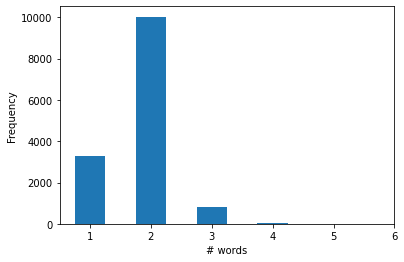

In [ ]:
names = data["name"].str.lower()
print('Number of samples:',len(data))
print('Is there any capitalized letter in colour names?', bool(sum([1-x.islower() for x in names.values])))


colname_len = [len(x) for x in names.str.split(" ", n = -1).values]
print('Max number of words in colour names:', max(colname_len))
print('Dsitribution of the number of words in colour names:')
plt.hist(colname_len, align = 'left')      #use this to draw histogram of your data
plt.xlabel('# words')
plt.ylabel('Frequency')
plt.show()

## Task 1: a neural network to get a RGB color vector from a word

The approach we have chosen for this task is to vectorize the color names by tokenizing each **word** and matching them with .pre-trained embeddings.

### Tokenizing at word level

We will consider that every color name is a sequences of words to used pre-trained word embeddings. A common trick in NLP is limiting the number of tokens (words) to exclude the rare ones to improve the generalization of the model. However, we have here a specialised and nuanced vocabulary for color names. As a result the size of the vocabulary is not too big, plus it is important to keep nuances because we want the model to predict nuanced colors.

In [ ]:
t = Tokenizer(num_words=None)
t.fit_on_texts(names)
word_index = t.word_index
print('Found %s unique tokens.' % len(word_index))

Found 6371 unique tokens.


 We have seen in a our short exploration of the dataset that color names have different length from 1 to 6. We then convert them to sequences that we pad them, to get a 6 long sequence for each name. 

In [ ]:
maxlen = 6
tokenized = t.texts_to_sequences(names)
padded_names = preprocessing.sequence.pad_sequences(tokenized, maxlen=maxlen)

### Pre-trained embeddings

We have explored two families of pre-trained embeddings readily available online: the [GloVe](https://nlp.stanford.edu/projects/glove/) and [fastText](https://fasttext.cc/).

Each of them come in different versions depending of the corpus of texts it was trained on and the dimension of the word vectors. We retained the GloVe with 42B words, trained on Common Crawl and with dimension 300 as it yielded the best results in terms of error.

In [ ]:
# Download the pre-trained embeddings
#!wget http://nlp.stanford.edu/data/glove.42B.300d.zip

In [ ]:
# Unzip on drive
# import zipfile
# with zipfile.ZipFile('glove.42B.300d.zip', 'r') as zip_ref:
#     zip_ref.extractall('drive/MyDrive/dl_assignment_3')

In [ ]:
# Extract the words vectors from GloVe embeddings txt file
embeddings_index = {}
f = open(os.path.join('drive/MyDrive/dl_assignment_3', 'glove.42B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# Build our embedding matrix by matching the tokens (words) in our dataset to
# the pre-trained embeddings.

# Code inspired from
# https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

words_in_data = []
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        words_in_data.append(word)

# Save our embedding matrix
np.savetxt('drive/MyDrive/dl_assignment_3/embedding_matrix.csv', embedding_matrix, delimiter=',')

Found 1917494 word vectors.


In [ ]:
# Load our saved embedding matrix
embedding_matrix = np.loadtxt('drive/MyDrive/dl_assignment_3/embedding_matrix.csv',delimiter=',')

### Model

In [ ]:
# The RGB values are between 0 - 255
# scale them to be between 0 - 1
def norm(value):
    return value / 255.0

normalized_values = np.column_stack([norm(data["red"]), norm(data["green"]), norm(data["blue"])])


Now we build a LSTM model that reads sequences of words and produces a scaled-RGB triplet as output. This is a many-to-one sequential model. We use a single bidirectional LSTM layer as increasing the number of layers did not prove to be helpful.

Alternatives we considered and that we found were not more accurate than LSTM have been:

*   character level one-hot encoding of colour names,
*   replacing LSTM by unidirectional or bidirectional GRU layers,
*   implementing an one-dimesional convolution network,
*   variations of the number of LSTM layers and their sizes and activation function of the dense layer.

We add two dropout layers, use mean squared error as loss, adamax as optimizer and compute the mean absolute errror as metric.


In [ ]:
# Inititate, define and compile the model
model = Sequential()
model.add(Embedding(len(word_index)+1,300,input_length=6,weights=[embedding_matrix],trainable=True))
#model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.4))
model.add(Bidirectional(LSTM(16)))
#model.add(Dense(16, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation='sigmoid'))
model.compile(optimizer='adamax', loss='mse', metrics=['mae','acc'])
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 6, 300)            1911600   
_________________________________________________________________
dropout_50 (Dropout)         (None, 6, 300)            0         
_________________________________________________________________
bidirectional_31 (Bidirectio (None, 32)                40576     
_________________________________________________________________
dropout_51 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 3)                 99        
Total params: 1,952,275
Trainable params: 1,952,275
Non-trainable params: 0
_________________________________________________________________


We train the model with our dataset and stop after only 4 epochs as the validation loss does not appear to decrease anymore.

In [ ]:
# Set a callback, to stop the training when the validation loss does not decrease anymore
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Train the model
history = model.fit(padded_names, normalized_values,
                    epochs=150,
                    batch_size=2048,
                    callbacks=[callback],
                    validation_split=0.1)

Epoch 1/150
7/7 [==============================] - 5s 152ms/step - loss: 0.0797 - mae: 0.2419 - acc: 0.4187 - val_loss: 0.0697 - val_mae: 0.2275 - val_acc: 0.5445
Epoch 2/150
7/7 [==============================] - 1s 77ms/step - loss: 0.0715 - mae: 0.2290 - acc: 0.4900 - val_loss: 0.0649 - val_mae: 0.2190 - val_acc: 0.5706
Epoch 3/150
7/7 [==============================] - 1s 81ms/step - loss: 0.0664 - mae: 0.2198 - acc: 0.5274 - val_loss: 0.0623 - val_mae: 0.2134 - val_acc: 0.5946
Epoch 4/150
7/7 [==============================] - 1s 77ms/step - loss: 0.0635 - mae: 0.2138 - acc: 0.5428 - val_loss: 0.0607 - val_mae: 0.2094 - val_acc: 0.6201
Epoch 5/150
7/7 [==============================] - 1s 75ms/step - loss: 0.0618 - mae: 0.2094 - acc: 0.5601 - val_loss: 0.0592 - val_mae: 0.2062 - val_acc: 0.6264
Epoch 6/150
7/7 [==============================] - 1s 82ms/step - loss: 0.0601 - mae: 0.2060 - acc: 0.5737 - val_loss: 0.0576 - val_mae: 0.2032 - val_acc: 0.6412
Epoch 7/150
7/7 [==========

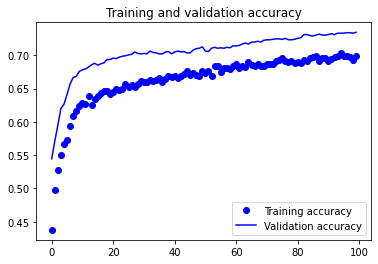

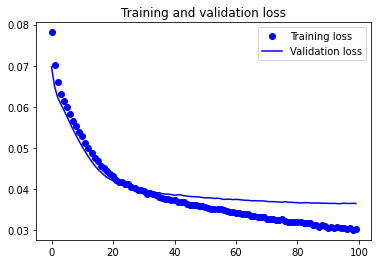

In [ ]:
# Plot the mean squared error and mean absolute error 
# in training and validation samples across epochs
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


### Results on test names

Now we are ready to predict color of a random name:

In [ ]:
# Plot a color image.
def plot_rgb(rgb):
    data = [[rgb]]
    plt.figure(figsize=(2,2))
    plt.imshow(data, interpolation='nearest')
    plt.show()

# Scale back network output to RGB values 
def scale(n):
    return int(n * 255) 

# Predict the RGB vector from the name
def predict(name):
    name = name.lower()
    tokenized = t.texts_to_sequences([name])
    padded = preprocessing.sequence.pad_sequences(tokenized, maxlen=maxlen)
    #one_hot = np_utils.to_categorical(padded, num_classes=num_classes)
    pred = model.predict(padded)[0]
    r, g, b = scale(pred[0]), scale(pred[1]), scale(pred[2])
    print(name + ',', 'R,G,B:', r,g,b)
    plot_rgb(pred)

We see our network can correctly predict the colour from names of colours without nuances.

black, R,G,B: 60 57 60


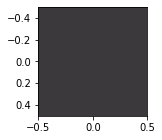

white, R,G,B: 241 236 225


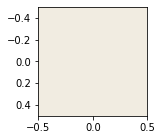

In [ ]:
predict("black")
predict("white")

It can also correctly predict lighter and darker nuances of a color.

light blue, R,G,B: 174 211 221


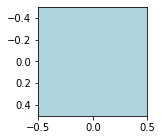

blue, R,G,B: 91 143 182


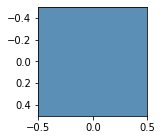

dark blue, R,G,B: 40 68 112


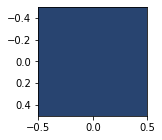

In [ ]:
predict("light blue")
predict("blue")
predict("dark blue")

It can also correctly predict colors from objects which have characteristics colors such "brick", "ocean" and "egg".

brick, R,G,B: 150 97 77


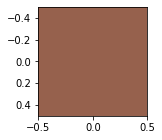

ocean, R,G,B: 98 149 161


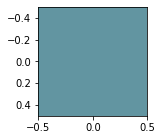

egg, R,G,B: 229 216 178


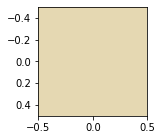

In [ ]:
predict("brick")
predict("ocean")
predict("egg")

Interestingly it can also correctly predict mix of colours with different intensities.

red yellow, R,G,B: 236 158 42


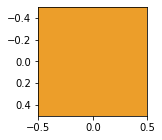

red red yellow, R,G,B: 235 107 32


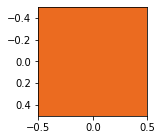

yellow yellow red, R,G,B: 234 162 46


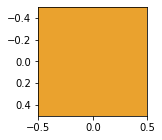

In [ ]:
predict("red yellow")
predict("red red yellow")
predict("yellow yellow red")

## Task 2: a neural network to get a word from a RGB color vector

Now we reverse the task. It becomes a one-to-many sequence problem, from one RGB vector to a set of word descriptors. Our approach consists in:

*   working at word level,
*   encoding the colour names with the GloVe embeddings and use the embedded names as target in training,
*   using the RGB vectors repeated several ($n$) times to match the length of the padded word sequences composing the colour names,
*   a stack of bidirectional LSTM layers of increasing sizes followed by a dense layer,
*   using cosine similarity, a metric commonly used in NLP, as loss.

Our network outputs $n$ vectors with dimension 300. To predict a colour name from a test RGB vector, for each of the $n$ output vectors, we find the closest vector in the embedding space in terms of cosine similarity and corresponding word.

Several alternatives were tried but abandonned:

*   reconstructing colour names with character level one-hot encoding,
*   GRU layers instead of LSTM layers,
*   implementing an one-dimesional convolution network,
*   variations of the number of LSTM layers and their sizes and activation function of the dense layer.

For the prediction of test RGB vectors, we have tried to find the closest vectors in different spaces. Those generated by 
*   the GloVe pre-trained embeddings matrix of different dimensions,
*   the GloVe pre-trained embeddings matrix restricted to the words in our dataset, 
*   the GloVe embedding matrix restricted to the words in our dataset trained in Task 1.

This problem is much harder than Task 1. We first tried using all the names in the dataset but we did not obtain good results. We find that the vast majority of color names in our dataset has a length inferior to two, so we use only this subset to ease the learning process. We show below a version of our pipeline and model for all colour names to show it can handle larger sequences too.

### Pre-processing



We generate the subset of words of length 2.

Number of samples: 10032
Is there any capitalized letter in colour names? False
Max number of words in colour names: 2
Dsitribution of the number of words in colour names:


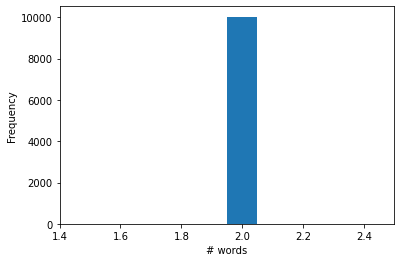

In [ ]:
# Subset data with color name of length 2
colname_len_df = pandas.DataFrame(colname_len,columns =['len'])
data_inf2 = data[colname_len_df['len']==2]

names_inf2 = data_inf2["name"].str.lower()

print('Number of samples:',len(data_inf2))
print('Is there any capitalized letter in colour names?', bool(sum([1-x.islower() for x in names_inf2.values])))

colname_len_inf2 = [len(x) for x in names_inf2.str.split(" ", n = -1).values]
print('Max number of words in colour names:', max(colname_len_inf2))
print('Dsitribution of the number of words in colour names:')

# Plot the distribution of names length
plt.hist(colname_len_inf2, align = 'left')
plt.xlabel('# words')
plt.ylabel('Frequency')
plt.show()


We tokenize at word level, match the words in colour names to the pre-trained embeddings and obtain our embedding matrix.

In [ ]:
# Fit the tokenizer and build the word index
t_inf2 = Tokenizer(num_words=None)
t_inf2.fit_on_texts(names_inf2)
word_index_inf2 = t_inf2.word_index
print('Found %s unique tokens.' % len(word_index_inf2))

# Get the embedding matrix by 
# matching the words in colour names to the pre-trained embeddings

words_in_data = []
embedding_matrix_inf2 = np.zeros((len(word_index_inf2) + 1, 300))
for word, i in word_index_inf2.items():
    embedding_vector = embeddings_index.get(word)
    words_in_data.append(word)    
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_inf2[i] = embedding_vector

        

np.savetxt('drive/MyDrive/dl_assignment_3/embedding_matrix_inf2.csv', embedding_matrix_inf2, delimiter=',')

Found 4600 unique tokens.


We generate our training input by embedding our colour name sequences. 

In [ ]:
# Generate the embedding layer
embedding_layer = Embedding(len(word_index_inf2) + 1,
                            300,
                            weights=[embedding_matrix_inf2],
                            input_length=2,
                            trainable=False)

# Convert the colour names to sequences and padd them to length 2
tokenized_inf2 = t_inf2.texts_to_sequences(names_inf2)
word_index_inf2 = t_inf2.word_index
padded_names_inf2 = preprocessing.sequence.pad_sequences(tokenized_inf2, maxlen=2)

embedded_seq = embedding_layer(padded_names_inf2)

# Get the normalized RBG vectors
normalized_values_inf2 = np.column_stack([norm(data_inf2["red"]), norm(data_inf2["green"]), norm(data_inf2["blue"])])

### Model

Our model is composed of 3 bidirectional LSTM layers of increasing size, one LSTM layer, one dropout layer and one final dense layer. 

In [ ]:
model2 = Sequential()
model2.add(RepeatVector(2, input_shape=(3,)))
model2.add(Bidirectional(LSTM(32, return_sequences = True)))
model2.add(Bidirectional(LSTM(64, return_sequences = True)))
model2.add(Bidirectional(LSTM(128, return_sequences = True)))
model2.add(LSTM(256, return_sequences = True))
model2.add(Dropout(0.2))
model2.add(TimeDistributed(Dense(300)))
model2.compile(optimizer='adam', loss='cosine_similarity', metrics = ['mse','acc'])
model2.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
repeat_vector_4 (RepeatVecto (None, 2, 3)              0         
_________________________________________________________________
bidirectional_44 (Bidirectio (None, 2, 64)             9216      
_________________________________________________________________
bidirectional_45 (Bidirectio (None, 2, 128)            66048     
_________________________________________________________________
bidirectional_46 (Bidirectio (None, 2, 256)            263168    
_________________________________________________________________
lstm_51 (LSTM)               (None, 2, 256)            525312    
_________________________________________________________________
dropout_56 (Dropout)         (None, 2, 256)            0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 2, 300)          

Training of the model.

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model2.fit(normalized_values_inf2,embedded_seq,
                    epochs=100,
                    batch_size=256,
                    #callbacks=[callback],
                    validation_split=0.1)

Epoch 1/100
36/36 [==============================] - 17s 112ms/step - loss: -0.3939 - mse: 0.1628 - acc: 0.1084 - val_loss: -0.5184 - val_mse: 0.1607 - val_acc: 0.1519
Epoch 2/100
36/36 [==============================] - 3s 80ms/step - loss: -0.5040 - mse: 0.1612 - acc: 0.1469 - val_loss: -0.5236 - val_mse: 0.1613 - val_acc: 0.1519
Epoch 3/100
36/36 [==============================] - 3s 80ms/step - loss: -0.5121 - mse: 0.1619 - acc: 0.1467 - val_loss: -0.5268 - val_mse: 0.1617 - val_acc: 0.1663
Epoch 4/100
36/36 [==============================] - 3s 79ms/step - loss: -0.5172 - mse: 0.1619 - acc: 0.1584 - val_loss: -0.5281 - val_mse: 0.1618 - val_acc: 0.1648
Epoch 5/100
36/36 [==============================] - 3s 79ms/step - loss: -0.5188 - mse: 0.1620 - acc: 0.1567 - val_loss: -0.5285 - val_mse: 0.1618 - val_acc: 0.1673
Epoch 6/100
36/36 [==============================] - 3s 80ms/step - loss: -0.5223 - mse: 0.1627 - acc: 0.1620 - val_loss: -0.5283 - val_mse: 0.1619 - val_acc: 0.1663
Ep

### Test on RGB vectors

Define a function that takes a RGB vector, finds the vectors from the pre-trained GloVe embedding matrix that are the closest to the vectors output by our network for the RGB, and the corresponding words.

In [ ]:
# Code inspired by
# https://github.com/airalcorn2/Color-Names/blob/master/color_names.py

def generate_name(rgb, max_tokens, embedd_matrix, words_in_data, color2words, neighbors):
    """Generate name from a color.
    :param rgb:
    :param max_tokens:
 
   :param word2vec:
    :param color2words:
    :return:
    """

    # Reshape the rgb vector
    X_test = np.zeros((max_tokens, 3))
    X_test[0] = [x/255. for x in rgb]
    # Get network prediction
    word_vecs = color2words.predict(X_test)[0]
    
    color_name = []
    embedd_matrix2 = np.copy(embedd_matrix)

    # For each vector in network output
    # find the closest vectors in embedding matrix and 
    # get the word from the word index
    nb = 1
    for word in range(max_tokens):

        word_vec = word_vecs[word]
        word_mag = np.sqrt(np.dot(word_vec, word_vec))
        dotted = np.dot(word_vec, embedd_matrix2.T)
        mags = []
        for i in range(embedd_matrix2.shape[0]):
            mags.append(np.sqrt(np.dot(embedd_matrix2[i], embedd_matrix2[i])))

        mags = np.array(mags)
        cosine = dotted / (word_mag * mags)

        keeps = []
        print("Closest", neighbors,"word(s) to output vector number",nb)
        for idx in cosine.argsort()[-neighbors:][::-1]:
            print(words_in_data[idx])
            keeps.append(idx)
            color_name.append(words_in_data[idx])

        print()
        nb= nb + 1
    return(color_name)

In some cases, our model is able to predict sensible non trivial names like "beautiful beige" or "dark purple".

[115, 16, 100]


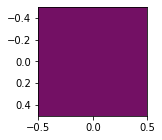

Closest 1 word(s) to output vector number 1
dark

Closest 1 word(s) to output vector number 2
purple

Predicted colour name: dark purple


In [ ]:
rgb = np.random.randint(low = 0,high = 255, size = 3).tolist()
print(rgb)
plot_rgb(rgb)
pred_name = generate_name(rgb, 2, np.array(list(embeddings_index.values())), list(embeddings_index.keys()), model2,1)
print("Predicted colour name:"," ".join(pred_name))

[203, 186, 169]


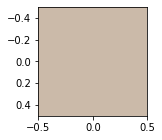

Closest 1 word(s) to output vector number 1
beautiful

Closest 1 word(s) to output vector number 2
beige

Predicted colour name: beautiful beige


In [ ]:
rgb = data.iloc[random.randint(0,len(data)),1:4].tolist()
print(rgb)
plot_rgb(rgb)
pred_name = generate_name(rgb, 2, np.array(list(embeddings_index.values())), list(embeddings_index.keys()), model2,1)
print("Predicted colour name:"," ".join(pred_name))

It sometimes predicts mix of colours.

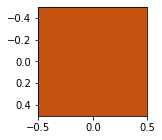

Closest 1 word(s) to output vector number 1
red

Closest 1 word(s) to output vector number 2
orange

Predicted colour name: red orange


In [ ]:
plot_rgb([195, 82, 14])
pred_name = generate_name([195, 82, 14], 2, np.array(list(embeddings_index.values())), list(embeddings_index.keys()), model2,1)
print("Predicted colour name:"," ".join(pred_name))

Often it predicts correct but trivial names.

[50, 108, 182]


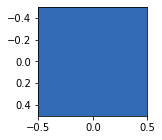

Closest 1 word(s) to output vector number 1
blue

Closest 1 word(s) to output vector number 2
blue

Predicted colour name: blue blue


In [ ]:
from operator import itemgetter
rgb = np.random.randint(low = 0,high = 255, size = 3).tolist()
print(rgb)
plot_rgb(rgb)
pred_name = generate_name(rgb, 2, np.array(list(embeddings_index.values())), list(embeddings_index.keys()), model2,1)
print("Predicted colour name:"," ".join(pred_name))                        

When we try to find closest vectors in the embedding matrix restricted to the words in our dataset, we obtain creative colour names but hard to find them related to the visual.

[89, 140, 65]


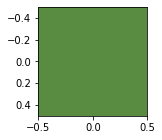

Closest 3 word(s) to output vector number 1
bricktone
razzmic
liseran

Closest 3 word(s) to output vector number 2
tropaz
tainoi
liseran

Possible combination for the colour name: razzmic tropaz


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
from operator import itemgetter
rgb = np.random.randint(low = 0,high = 255, size = 3).tolist()
print(rgb)
plot_rgb(rgb)
pred_name = generate_name(rgb, 2, embedding_matrix_inf2[1:], words_in_data, model2,3)
print("Possible combination for the colour name:"," ".join(itemgetter(np.random.randint(0,3,1)[0],
                                                                       np.random.randint(3,6,1)[0])(pred_name)))

### Version for all the colour names - up to 6 words

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            300,
                            weights=[embedding_matrix],
                            input_length=2,
                            trainable=False)
tokenized = t.texts_to_sequences(names)
padded_names = preprocessing.sequence.pad_sequences(tokenized, maxlen=6)

embedded_seq = embedding_layer(padded_names)
embedded_seq.shape

TensorShape([14157, 6, 300])

In [ ]:
model3 = Sequential()
model3.add(RepeatVector(6, input_shape=(3,)))
model3.add(Bidirectional(LSTM(32, return_sequences = True)))
model3.add(Bidirectional(LSTM(64, return_sequences = True)))
model3.add(Bidirectional(LSTM(128, return_sequences = True)))
model3.add(LSTM(256, return_sequences = True))
model3.add(Dropout(0.2))
model3.add(TimeDistributed(Dense(300)))
model3.compile(optimizer='adam', loss='cosine_similarity', metrics = ['mse','acc'])
model3.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
repeat_vector_5 (RepeatVecto (None, 6, 3)              0         
_________________________________________________________________
bidirectional_47 (Bidirectio (None, 6, 64)             9216      
_________________________________________________________________
bidirectional_48 (Bidirectio (None, 6, 128)            66048     
_________________________________________________________________
bidirectional_49 (Bidirectio (None, 6, 256)            263168    
_________________________________________________________________
lstm_55 (LSTM)               (None, 6, 256)            525312    
_________________________________________________________________
dropout_57 (Dropout)         (None, 6, 256)            0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 6, 300)          

The loss values obtained with the complete dataset are much higher.

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model3.fit(normalized_values,embedded_seq,
                    epochs=100,
                    batch_size=256,
                    #callbacks=[callback],
                    validation_split=0.1)

Epoch 1/100
50/50 [==============================] - 25s 206ms/step - loss: -0.1168 - mse: 0.0483 - acc: 0.0283 - val_loss: -0.1492 - val_mse: 0.0472 - val_acc: 0.0457
Epoch 2/100
50/50 [==============================] - 9s 182ms/step - loss: -0.1465 - mse: 0.0478 - acc: 0.0442 - val_loss: -0.1506 - val_mse: 0.0478 - val_acc: 0.0470
Epoch 3/100
50/50 [==============================] - 9s 189ms/step - loss: -0.1495 - mse: 0.0482 - acc: 0.0451 - val_loss: -0.1510 - val_mse: 0.0481 - val_acc: 0.0466
Epoch 4/100
50/50 [==============================] - 9s 181ms/step - loss: -0.1511 - mse: 0.0486 - acc: 0.0462 - val_loss: -0.1510 - val_mse: 0.0481 - val_acc: 0.0463
Epoch 5/100
50/50 [==============================] - 9s 180ms/step - loss: -0.1512 - mse: 0.0486 - acc: 0.0457 - val_loss: -0.1523 - val_mse: 0.0482 - val_acc: 0.0467
Epoch 6/100
50/50 [==============================] - 9s 179ms/step - loss: -0.1535 - mse: 0.0488 - acc: 0.0466 - val_loss: -0.1526 - val_mse: 0.0480 - val_acc: 0.04

We can obtain the closest words for each of the 6 of the output vector.

[135, 203, 28]


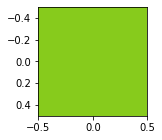

Closest 3 word(s) to output vector number 1
loeen
beachcrest
hodley

Closest 3 word(s) to output vector number 2
dartsmouth
mopboard
corlsbud

Closest 3 word(s) to output vector number 3
driftscape
arylide
aganthus

Closest 3 word(s) to output vector number 4
aganthus
rubiate
beachcrest

Closest 3 word(s) to output vector number 5
aganthus
corlsbud
jamesboro

Closest 3 word(s) to output vector number 6
aganthus
beachcrest
bricktone

Possible combination for the colour name: beachcrest dartsmouth


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
from operator import itemgetter
rgb = np.random.randint(low = 0,high = 255, size = 3).tolist()
print(rgb)
plot_rgb(rgb)
pred_name = generate_name(rgb, 6, embedding_matrix_inf2[1:], words_in_data, model3,3)
print("Possible combination for the colour name:"," ".join(itemgetter(np.random.randint(0,3,1)[0],
                                                                       np.random.randint(3,6,1)[0])(pred_name)))

## Report - summary

### Task 1

1. Which is the best model you have build? (architecture, word representations, etc.)

Approach and model:


*   Tokenization at word level,
*   GloVe pre-trained embeddings with 42B words, trained on Common Crawl and with dimension 300,
*   Archictecture: embedding layer, single bidirectional LSTM, two dropout layers, one final dense layer,
*   training with mean squared error as loss, adamax as optimizer.

<br>

2. Report in terms of accuracy

We obtained a validation MSE of 0.0365.

<br>

3. Examples


brick, R,G,B: 150 97 77


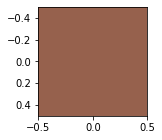

red yellow, R,G,B: 236 158 42


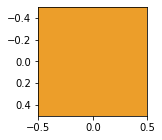

red red yellow, R,G,B: 235 107 32


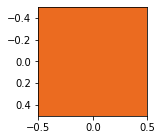

dark blue, R,G,B: 40 68 112


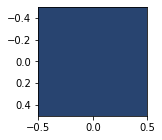

In [ ]:
predict("brick")
predict("red yellow")
predict("red red yellow")
predict("dark blue")

### Task 2

1. Which is the best model you have build? (architecture, word representations, etc.)

Approach and model:

*   Tokenization at word level of colour names,
*   Embedding of colour names with the same GloVe pre-trained embeddings,
*   Archictecture: 3 bidirectional LSTM layers and one LSTM layer of increasing size, one dropout layer, one final dense layer,
*   Training with cosine similarity as loss and adam optimizer,
*   Predicting colour names by looking for the closest vectors in the pre-trained embedding matrix

<br>

2. Report, in terms of accuracy

In validation set we obtained a cosine similarity of 0.5508 and an accuracy of 0.17 (not very informative because our approach treats the problem as a regression problem).

<br>

3. Examples 


[203, 186, 169]


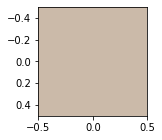

Closest 1 word(s) to output vector number 1
beautiful

Closest 1 word(s) to output vector number 2
beige

Predicted colour name: beautiful beige


In [ ]:
rgb = [203, 186, 169]
print(rgb)
plot_rgb(rgb)
pred_name = generate_name(rgb, 2, np.array(list(embeddings_index.values())), list(embeddings_index.keys()), model2,1)
print("Predicted colour name:"," ".join(pred_name))

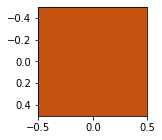

Closest 1 word(s) to output vector number 1
red

Closest 1 word(s) to output vector number 2
orange

Predicted colour name: red orange


In [ ]:
plot_rgb([195, 82, 14])
pred_name = generate_name([195, 82, 14], 2, np.array(list(embeddings_index.values())), list(embeddings_index.keys()), model2,1)
print("Predicted colour name:"," ".join(pred_name))

[115, 16, 100]


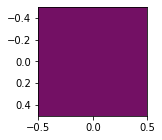

Closest 1 word(s) to output vector number 1
dark

Closest 1 word(s) to output vector number 2
purple

Predicted colour name: dark purple


In [ ]:
rgb = [115, 16, 100]
print(rgb)
plot_rgb(rgb)
pred_name = generate_name(rgb, 2, np.array(list(embeddings_index.values())), list(embeddings_index.keys()), model2,1)
print("Predicted colour name:"," ".join(pred_name))